In [1]:
import torch
import numpy as np
import models,utils,camera
import matplotlib.pyplot as plt
from tqdm import tqdm
import datasets
import matplotlib.pyplot as plt
from camera import Camera_v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = datasets.GSO(r"C:\Users\Admin\Documents\Dataset\GSO_image",output_image=3)
cam  = Camera_v2(35,35,32,32)


BATCH_SIZE = 14
LEARNING_RATE = 0.0001
EPOCH = 2000

c:\Users\Admin\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = models.MultiViewModel().to(device)
model = torch.load('new_best4.pth').to(device)

In [4]:
loader = torch.utils.data.DataLoader(dataset,
                                    batch_size=BATCH_SIZE, shuffle=True,
                                    num_workers=4,drop_last = True)


optimizer = torch.optim.AdamW(list(model.parameters()),lr=LEARNING_RATE)
loss = torch.nn.MSELoss(reduce="mean")



In [4]:
model.train()
for epoch in range(EPOCH):
    mean = 0
    train_loop = tqdm(loader)
    for i,batch in enumerate(train_loop):
        l = 0
        X=batch['X'].to(device)
        Y = batch['Y'].to(device)
        relative_M = batch['relative_M'].to(device)
        output = model(X,relative_M)
        l += ((output[...,:3,:,:]-Y[...,:3,:,:])**2*Y[...,-1:,:,:]).mean()
        l += ((output[...,-1,:,:]-Y[...,-1,:,:])**2).mean()
        mean += float(l)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_loop.set_description(f"training {epoch+1}/{EPOCH}")
        train_loop.set_postfix(loss_task = float(l),tot_loss=mean/(i+1)/0.004)

  0%|          | 0/73 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model,'new_best4.pth')

In [ ]:
for batch_test in loader:
    break

In [ ]:
batch_test['X'].shape

torch.Size([14, 4, 128, 128])

In [ ]:
#X = torch.concat([torch.ones(1,4,512,512),torch.zeros(15,4,512,512)],0).to(device)
model.eval()
with torch.no_grad():
    X = batch_test['X'].to(device)
    Y = batch_test['Y'].to(device)
    relative_M = batch_test['relative_M'].to(device)
    #relative_M[...,-1] += -0.4*relative_M[...,-2] 
    
    print(relative_M[0,:,:,:3])
    Y_model = model(X,relative_M)


tensor([[[ 5.7069e-01, -5.2710e-01,  6.2966e-01],
         [ 5.1162e-02,  7.8813e-01,  6.1338e-01],
         [-8.1957e-01, -3.1784e-01,  4.7675e-01]],

        [[ 5.7907e-01, -5.2413e-01,  6.2447e-01],
         [ 5.0795e-02,  7.8766e-01,  6.1401e-01],
         [-8.1369e-01, -3.2384e-01,  4.8274e-01]],

        [[ 1.0000e+00, -1.4157e-09,  1.8883e-09],
         [-1.2510e-09,  1.0000e+00,  7.3190e-09],
         [ 1.7823e-09, -1.3159e-10,  1.0000e+00]]], device='cuda:0')


In [ ]:
Y_model.shape

torch.Size([14, 3, 3, 128, 128])

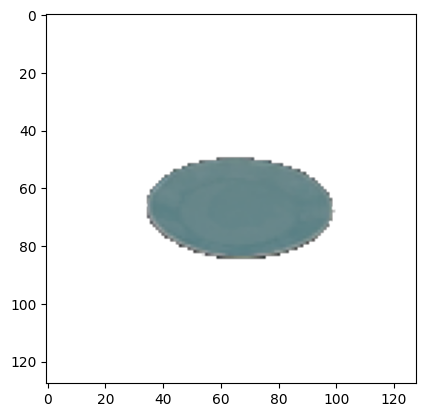

In [ ]:
i = 13
plt.imshow(X[i].detach().cpu().permute(1,2,0))

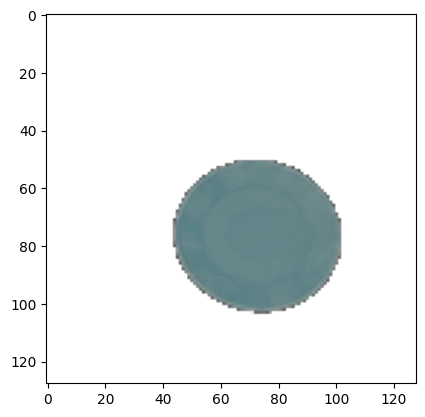

In [ ]:
j =1
plt.imshow(Y[i,j].detach().cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


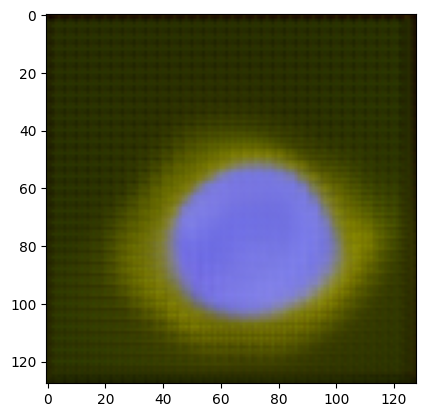

In [ ]:
plt.imshow((Y_model[i,j]).detach().cpu().permute(1,2,0))

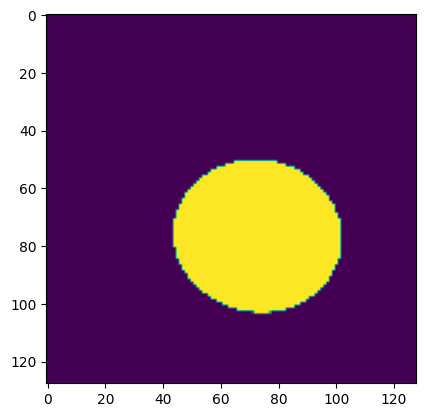

In [ ]:
plt.imshow(Y[i,j].detach().cpu().permute(1,2,0)[...,-1])

tensor(-0.0305)


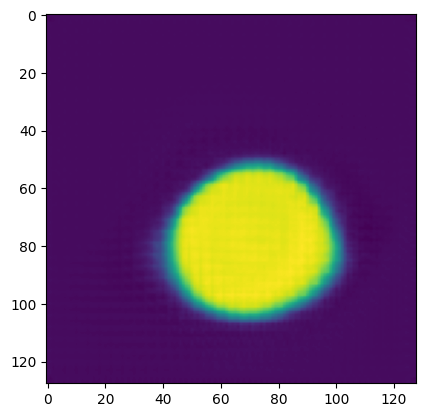

In [ ]:
plt.imshow(Y_model[i,j].detach().cpu().permute(1,2,0)[...,-1])
print(Y_model[i,j].detach().cpu().permute(1,2,0)[...,-1].min())

In [1]:
from camera import Camera_v2,transform_cam,relative_M
from utils import coordRay
import json,torch
f = open(r"C:\Users\Admin\Documents\Dataset\test.json") 
metadata = json.load(f)
M_init = torch.Tensor(metadata['cam'][0])
print(M_init)
M = torch.Tensor(metadata['cam'][1])
print(M)
Cam = Camera_v2(35,35,32,32)
rays = Cam.create(128,128)


M_relative = relative_M(M_init,M)[:3]
print(M_relative)
cam = transform_cam(rays,M_relative)
print(cam.shape)
spatial = torch.Tensor([0,0,0,0,0,0,0,0,-1])
spatial = spatial - torch.concat([torch.zeros(6),M_relative[...,-1]],-1)
spatial = spatial[None,None]
res = coordRay(spatial,cam.reshape(1,-1,3))[0,:,0].reshape(128,128,6)
print(res.shape)
print()
print(M_relative)
print(M_relative[...,:3,-3])

c:\Users\Admin\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[-1.0000e+00,  1.5100e-07, -1.1400e-14,  0.0000e+00],
        [ 0.0000e+00,  7.5498e-08,  1.0000e+00,  1.0000e+00],
        [ 1.5100e-07,  1.0000e+00, -7.5498e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-4.3711e-08,  4.3711e-08,  1.0000e+00,  1.0000e+00],
        [ 1.0000e+00,  1.9107e-15,  4.3711e-08,  0.0000e+00],
        [ 0.0000e+00,  1.0000e+00, -4.3711e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[ 4.3711e-08,  1.0728e-07, -1.0000e+00, -1.0000e+00],
        [ 7.5498e-08,  1.0000e+00,  1.0728e-07,  7.5498e-08],
        [ 1.0000e+00, -7.5498e-08,  4.3711e-08, -1.0000e+00]])
torch.Size([128, 128, 3])
torch.Size([128, 128, 6])

tensor([[ 4.3711e-08,  1.0728e-07, -1.0000e+00, -1.0000e+00],
        [ 7.5498e-08,  1.0000e+00,  1.0728e-07,  7.5498e-08],
        [ 1.0000e+00, -7.5498e-08,  4.3711e-08, -1.0000e+00]])
tensor([ 1.0728e-07,  1.0000e+00, -7.5498e-08])


In [ ]:
pos_x,pos_y = -1,-1
print(rays[pos_x,pos_y])
print(cam[pos_x,pos_y])
print(res[pos_x,pos_y])

tensor([ 0.1796, -0.1827, -0.9666])
tensor([ 0.9666, -0.1827,  0.1796])
tensor([ 9.6663e-01, -1.8268e-01,  1.7961e-01, -1.3560e-08, -1.7961e-01,
        -1.8268e-01])


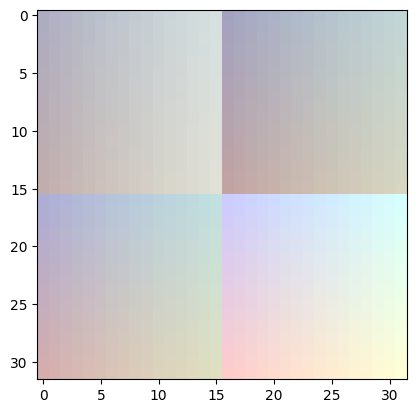

In [ ]:
import models
import torch
import numpy as np
import matplotlib.pyplot as plt
grid = models.build_grid((16,16))
info  = torch.FloatTensor([[1.,2.],[3.,4.]]).unsqueeze(-1)
result = grid.reshape(1,16,1,16,4) + info.reshape(2,1,2,1,1)
result = result.reshape(32,32,4)/5
plt.imshow(result)